<a href="https://colab.research.google.com/github/ZacharySBrown/vcu-scma440-2021q1/blob/master/examples/6a_multiple_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Fetch Data
Press the play button in Google Colab or press Shift+Enter execute the cell below to download and load the data and packages for this assignment

This will setup you environment and load a DataFrame called `bankdata` that contains the bank data from Makridakis Chapter 6.

In [50]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display


from scipy.stats import t, f

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 16

!curl https://vcu-scma-440.s3.amazonaws.com/data/bankdata.csv > bankdata.csv

bankdata = pd.read_csv('bankdata.csv', parse_dates=['date']).set_index('date').rename(columns={'34': 'mo_34'})

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1687  100  1687    0     0  20325      0 --:--:-- --:--:-- --:--:-- 20573


# Inspecting the data

Before we get started with any analysis, let's begin by taking a look at the data and plotting the four columns

In [51]:
bankdata.head()

,balance,aaa,mo_34
date,,,
2000-01-01,360071,5.94,5.31
2000-02-01,361217,6.00,5.60
2000-03-01,358774,6.08,5.49
2000-04-01,360271,6.17,5.80
2000-05-01,360139,6.14,5.61


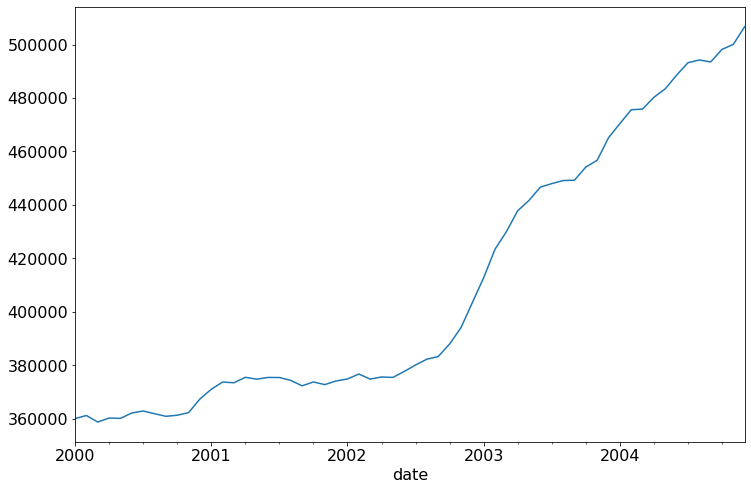

In [52]:
bankdata['balance'].plot()

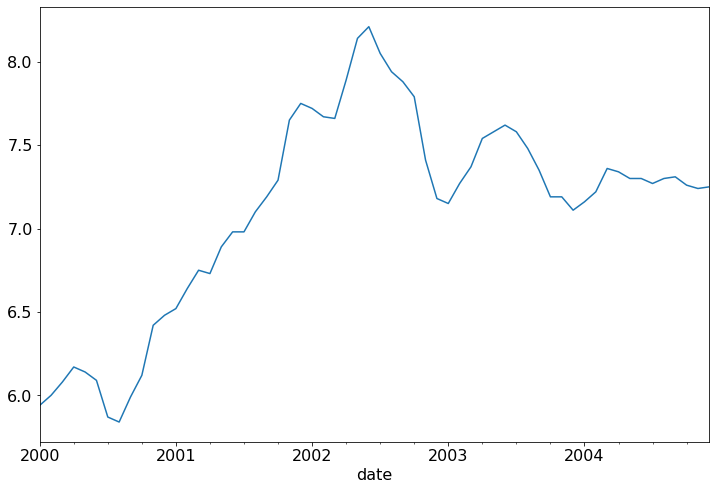

In [53]:
bankdata['aaa'].plot()

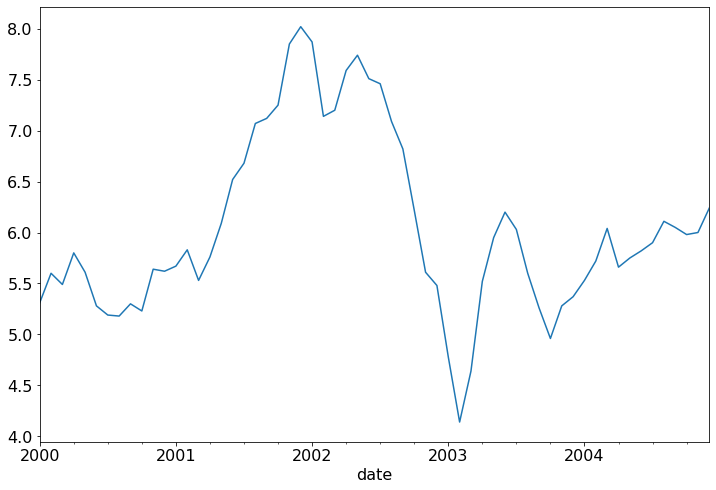

In [54]:
bankdata['mo_34'].plot()

# Creating Difference Variables

We'll want to carry out some plreliminary data preparation on our data, namely creating several new variables as the difference of month-to-month values in the original variables. We can do this using the `.diff()` function: 

```
data['my_diff_column'] = data['my_original_column'].diff()
```

Below we'll carry this out for the `balance` and `34` columns, naming the new columns containing the differences as `d_balance` and `d_34`. 

**Note here that this introduces a single row with `NaN` in it from taking the first difference, which we'll drop using `data = data.dropna()`**


In [55]:
bankdata['d_balance'] = bankdata['balance'].diff()
bankdata['d_mo_34'] = bankdata['mo_34'].diff()
bankdata = bankdata.dropna()

bankdata.head()

,balance,aaa,mo_34,d_balance,d_mo_34
date,,,,,
2000-02-01,361217,6.00,5.60,1146.0,0.29
2000-03-01,358774,6.08,5.49,-2443.0,-0.11
2000-04-01,360271,6.17,5.80,1497.0,0.31
2000-05-01,360139,6.14,5.61,-132.0,-0.19
2000-06-01,362164,6.09,5.28,2025.0,-0.33


# Inspecting data relationships

As we have seen before, we can plot relationships between individual pairs of data points, we can use `data.plot.scatter('x_column', 'y_column')`. If we're interested in plotting all relationships at once in a _scatter plot matrix_, we can use `pandas.plotting.scatter_matrix(data)`, which will plot a matrix of scatter plots for all the columsn in the `DataFrame`. 



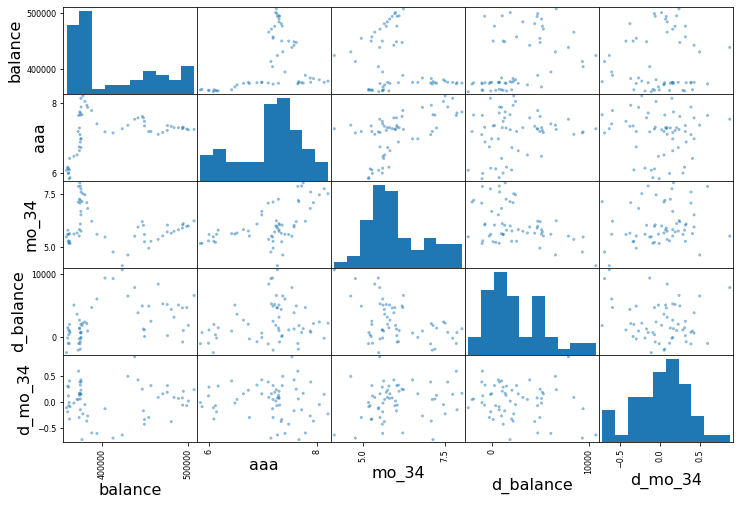

In [56]:
my_figure = pd.plotting.scatter_matrix(bankdata)

We can similarly calculate the correlation coefficient for all of the pairs of variables using the `data.corr()` function, e.g.:

```
bankdata.corr()
```

In [57]:
bankdata.corr()

,balance,aaa,mo_34,d_balance,d_mo_34
balance,1.000000,0.330050,-0.265663,0.432892,0.043118
aaa,0.330050,1.000000,0.576137,0.197073,-0.077555
mo_34,-0.265663,0.576137,1.000000,-0.447305,0.173994
d_balance,0.432892,0.197073,-0.447305,1.000000,-0.171200
d_mo_34,0.043118,-0.077555,0.173994,-0.171200,1.000000


Note that althrough there's not a clear visible association between the `d_balance` and `aaa`, there's still a non-zero correlation between the variables (similarly for `d_balance` and `34`).  

# Fitting a preliminary Linear Model

To fit a linear model using ordinary least squares (OLS) estimation, we can use the syntax below. 

In [58]:
model = ols('d_balance ~ aaa + mo_34 + d_mo_34', bankdata)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              d_balance   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     19.12
Date:                Mon, 15 Mar 2021   Prob (F-statistic):           1.28e-08
Time:                        20:03:35   Log-Likelihood:                -535.50
No. Observations:                  59   AIC:                             1079.
Df Residuals:                      55   BIC:                             1087.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4518.3745   3421.070     -1.321      0.1

From the output of the above, it appears that the overall regression is significant, as the p-value for the F-statistic (labeled as "Prob (F-statistic)"), is a number much less than a standard significance level of 0.05. 

It also appears that the independent variables `aaa` and `mo_34` both display a significant relationship to the dependent variable, while the `d_mo_34` variable (the difference values) do _not_. This is due to the p-value for the t-test for each variable (labeled here as "P>|t|") being much smaller than an standard confidence level of 0.05. 

# Exploring the validity of assumptions

When carrying out a regression like this, we make several assumptions about the expected patterns in our data. Some of these are:

1. Model form
2. Independence of residuals
3. Homoscedasticity of residuals
4. Normaliity of residuals

To explore the validity of the assumptions on residuals, we can access the residuals of the fit using `results.resid`. 

Below, we set the residuals as a new column in our `DataFrame`

In [63]:
bankdata['residuals'] = results.resid

bankdata.head()

,balance,aaa,mo_34,d_balance,d_mo_34,residuals
date,,,,,,
2000-02-01,361217,6.00,5.60,1146.0,0.29,1176.842219
2000-03-01,358774,6.08,5.49,-2443.0,-0.11,-2903.701643
2000-04-01,360271,6.17,5.80,1497.0,0.31,1518.880346
2000-05-01,360139,6.14,5.61,-132.0,-0.19,-426.845761
2000-06-01,362164,6.09,5.28,2025.0,-0.33,972.990245


We'll first explore the independence of the residuals, in several different ways: 
1. Plotting the residuals
2. Examining an ACF plot of the residuals
3. Calculating the Durbin-Watson Statistic

We'll begin by simply plotting the residuals:

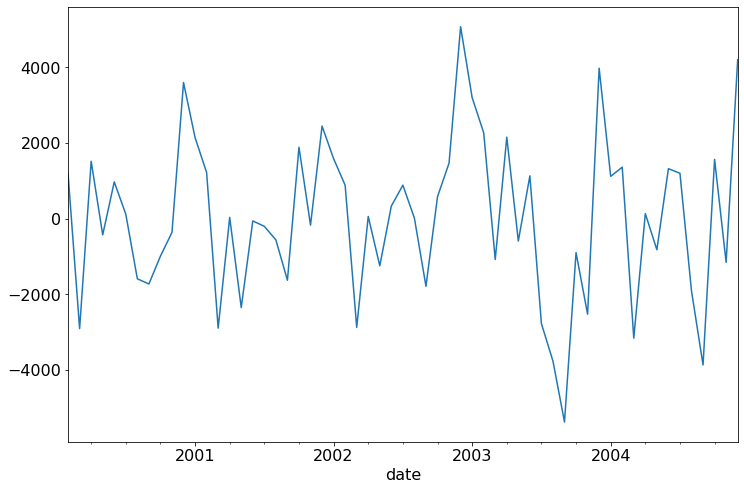

In [66]:
bankdata['residuals'].plot()

The residuals above exhibit a _slight_ seasonality. We can then check an ACF plot of the residuals to see if any strong autocorrelations exist for any lags.

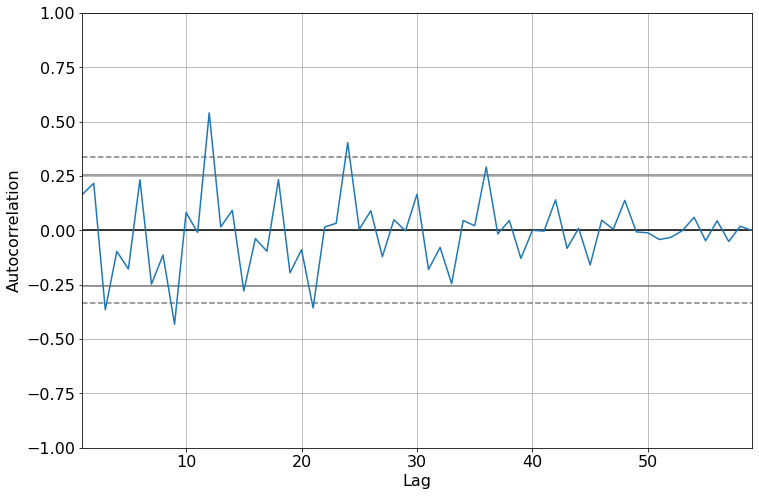

In [65]:
pd.plotting.autocorrelation_plot(bankdata['residuals'])

From the ACF plot above, it seems that there is a strong yearly seasonality for 12 and 24 month lags. 

Lastly, we can calcualte the Durbin-Watson statistic for the residuals, using `statsmodels.stats.stattools.durbin_watson`, imported as:


```
from statsmodels.stats.stattools import durbin_watson
```

This function can be used by simply passing in the residuals as an argument, e.g.:

```
durbin_watson(data['residuals'])
```

In [67]:
durbin_watson(bankdata['residuals'])

1.5986219310076784

Recall that this statistic ranges from 0 - 4, with a value of 2 indicating little to no autocorrelation in the data. Values between 0 and 2 indicate a slight positive autocorrelation in the data. 

# Creating Time-Based Dummy Variables

Up to now, we have considered the time-series nature of our data at all in our regression. The simplest way to do this is to create _dummy variables_ for each month in our data. To access the month portion of the dates in the `DataFrame` index, we can use `bankdata.index.month`, which will return the integer (1-12) corresponding to the month in year. 

Before we create dummy variables, let's save the month in a new column in our `DataFrame` called `month`

In [89]:
bankdata['month'] = bankdata.index.month

Our dummy variables should consist of 12 separate variables, all taking on values of either `0` or `1` depending on whether it is that paricular month or not. 

Befo

To create these dummy variables, we can use the `pandas` utility function `pd.get_dummies()` and pass our newly created `month` column, e.g.:
```
dummy_variables = pd.get_dummies(bankdata['month'], prefix='month')
```

In [99]:
dummy_variables = pd.get_dummies(bankdata['month'], prefix='month')
dummy_variables.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
2000-02-01,0,1,0,0,0,0,0,0,0,0,0,0
2000-03-01,0,0,1,0,0,0,0,0,0,0,0,0
2000-04-01,0,0,0,1,0,0,0,0,0,0,0,0
2000-05-01,0,0,0,0,1,0,0,0,0,0,0,0
2000-06-01,0,0,0,0,0,1,0,0,0,0,0,0


We can then use the `.join()` function to add the dummy variables as new columns to our `bankdata` `DataFrame`, and create a new `DataFrame` called `bankdata_months` e.g.:

```
bankdata_months = bankdata.join(dummy_variables)
```

_Note that `.join()` will join two `DataFrames` with a common `index`, which in this case is the same._

In [98]:
bankdata_months = bankdata.join(dummy_variables)
bankdata_months.head()

,balance,aaa,mo_34,d_balance,d_mo_34,residuals,month,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,,,,,
2000-02-01,361217,6.00,5.60,1146.0,0.29,1176.842219,2,0,1,0,0,0,0,0,0,0,0,0,0
2000-03-01,358774,6.08,5.49,-2443.0,-0.11,-2903.701643,3,0,0,1,0,0,0,0,0,0,0,0,0
2000-04-01,360271,6.17,5.80,1497.0,0.31,1518.880346,4,0,0,0,1,0,0,0,0,0,0,0,0
2000-05-01,360139,6.14,5.61,-132.0,-0.19,-426.845761,5,0,0,0,0,1,0,0,0,0,0,0,0
2000-06-01,362164,6.09,5.28,2025.0,-0.33,972.990245,6,0,0,0,0,0,1,0,0,0,0,0,0


# Fitting a Regression Model with Dummy Variables

Lastly, we want to fit our regression again with our time-based, monthly dummy variables. We can do this the same as before, only this time we specify the `bankdata_months` `DataFrame`, and update the formula to include the new monthly columns that we'd like to fit. 

In [101]:
model = ols('d_balance ~ aaa + mo_34 + d_mo_34 + month_1 + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + month_11 + month_12', bankdata_months)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              d_balance   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     23.83
Date:                Mon, 15 Mar 2021   Prob (F-statistic):           5.34e-16
Time:                        20:42:25   Log-Likelihood:                -493.16
No. Observations:                  59   AIC:                             1016.
Df Residuals:                      44   BIC:                             1047.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4172.3188   1738.794     -2.400      0.0